In [1]:
import kagglehub
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix

In [2]:
path_to_data = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

100%|██████████| 2.29G/2.29G [00:24<00:00, 98.9MB/s]

Extracting files...


Dataset downloaded at: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [3]:
dataset_directory = os.path.join(path_to_data, "chest_xray")
train_dir = os.path.join(dataset_directory, "train")
test_dir = os.path.join(dataset_directory, "test")
val_dir = os.path.join(dataset_directory, "val")

print(f"Dataset Contents: {os.listdir(dataset_directory)}")
print(f"Training Data: {os.listdir(train_dir)}")
print(f"Testing Data: {os.listdir(test_dir)}")
print(f"Validation Data: {os.listdir(val_dir)}")

Dataset Contents: ['__MACOSX', 'val', 'train', 'test', 'chest_xray']
Training Data: ['PNEUMONIA', 'NORMAL']
Testing Data: ['PNEUMONIA', 'NORMAL']
Validation Data: ['PNEUMONIA', 'NORMAL']


In [4]:
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_data = train_data_generator.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.


In [5]:
data_generator = ImageDataGenerator(rescale=1./255)
validation_data = data_generator.flow_from_directory(val_dir, target_size=(150, 150), batch_size=32, class_mode='binary')
test_data = data_generator.flow_from_directory(test_dir, target_size=(150, 150), batch_size=32, class_mode='binary')

Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
cnn_model = Sequential([
    Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(128, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
num_epochs = 10
train_history = cnn_model.fit(
    train_data,
    epochs=num_epochs,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=len(validation_data)
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.7553 - loss: 0.5405 - val_accuracy: 0.6875 - val_loss: 1.0738
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.8572 - loss: 0.3312 - val_accuracy: 0.7500 - val_loss: 0.8800
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.8841 - loss: 0.2691 - val_accuracy: 0.7500 - val_loss: 0.7069
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.9047 - loss: 0.2223 - val_accuracy: 0.7500 - val_loss: 0.7347
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.9166 - loss: 0.2328 - val_accuracy: 0.7500 - val_loss: 0.6732
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - accuracy: 0.9128 - loss: 0.2186 - val_accuracy: 0.8750 - val_loss: 0.4887
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - accuracy: 0.9207 - loss: 0.2004 - val_accuracy: 0.6250 - val_loss: 0.9671
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.9220 - loss: 0.1974 - val_accu

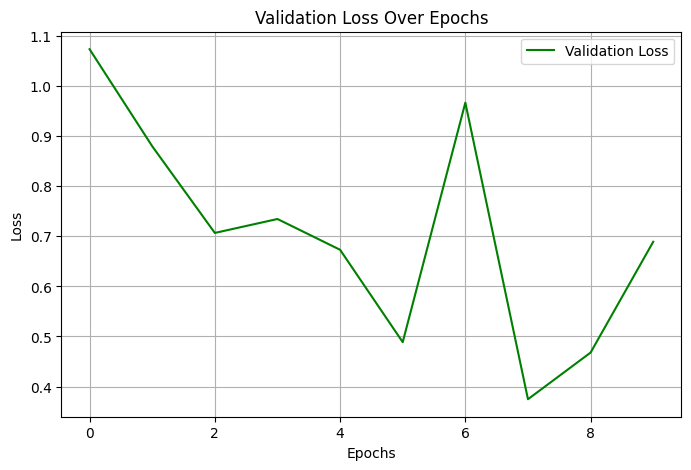

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(train_history.history['val_loss'], 'g', label='Validation Loss')
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [10]:
y_predictions = cnn_model.predict(test_data)
y_actual = test_data.classes
y_pred_labels = (y_predictions > 0.5).astype(int)

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 688ms/step


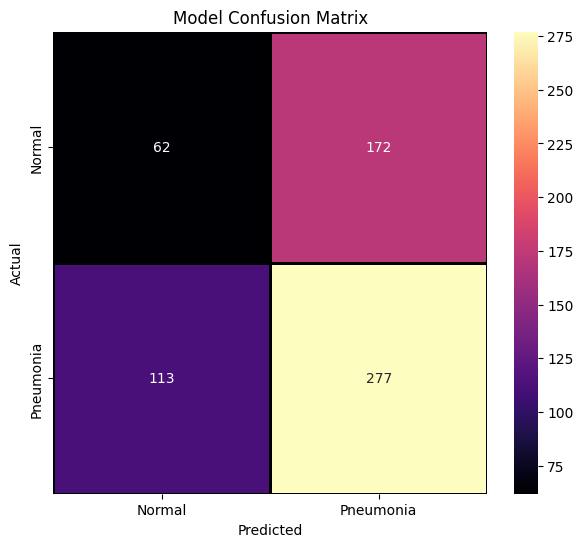

In [12]:
conf_matrix = confusion_matrix(y_actual, y_pred_labels)
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='magma', linewidths=1, linecolor='black', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Model Confusion Matrix')
plt.show()